# 第4章 予測モデルの評価と検証

## 4.2 ホールドアウト法と時系列データ

In [1]:
#
# code 4.1
#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.datasets import load_airpassengers

# データの読み込み
data = load_airpassengers()
df_ap = pd.DataFrame(data, columns=['y'])
df_ap.index = pd.date_range(
    start='1949-01-01', # 開始月
    periods=len(df_ap), # 期数
    freq='M'            # 間隔（Mは月を意味する）
)

In [2]:
#
# code 4.2
#

from pmdarima.model_selection import train_test_split

# データを学習データとテストデータに分割
train, test = train_test_split(
    df_ap['y'],   # 分割対象の時系列データ
    test_size=12, # 直近12ヶ月分をテストデータ
)

# 学習データとテストデータの期間を確認
print("Training data:", train.index.min(), train.index.max())
print("Test data:", test.index.min(), test.index.max())

Training data: 1949-01-31 00:00:00 1959-12-31 00:00:00
Test data: 1960-01-31 00:00:00 1960-12-31 00:00:00


In [3]:
#
# code 4.3
#

from sklearn.metrics import (
    mean_absolute_error,            # MAE
    mean_absolute_percentage_error, # MAPE
)
from pmdarima import AutoARIMA

# 学習データでARIMAモデルを構築
model = AutoARIMA(seasonal=True, m=12)
model.fit(train)

# テストデータの期間を予測
forecast = model.predict(n_periods=12)

# 評価指標（MAEとMAPE）を計算
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")

MAE: 14.90
MAPE: 3.10%


In [4]:
#
# code 3.3
#

# 予測結果をプロットする関数
def plot_prediction_results(
    y,                  # 実際の観測値
    fitted,             # 学習データ期間の予測値
    forecast=None,      # 将来予測の予測値
    conf=None,          # 将来予測の予測区間
):
    # 実測値のプロット
    plt.figure(figsize=(10, 5))
    plt.plot(
        y.index,        # 横軸
        y.values,       # 縦軸 
        label='Actual'  # ラベル名
    )
    # 学習データ期間の予測値のプロット
    plt.plot(
        fitted.index,   # 横軸
        fitted.values,  # 縦軸
        label='Fitted', # ラベル名
        color='green',  # 線の色
        linestyle=':'   # 線のスタイル
    )
    # 将来の予測値のプロット
    if forecast is not None:
        plt.plot(
            forecast.index,   # 横軸
            forecast,         # 縦軸
            label='Forecast', # ラベル名
            color='red',      # 線の色
            linestyle='--'    # 線のスタイル
        )
    # 将来の予測区間のプロット
    if conf is not None:
        plt.fill_between(
            forecast.index,            # 横軸
            conf[:, 0],                # 塗りつぶし幅の下限
            conf[:, 1],                # 塗りつぶし幅の上限
            color='red',               # 塗りつぶし幅の色
            alpha=0.1,                 # 塗りつぶし幅の透明度
            label='Predicted Interval' # ラベル名
        )
    plt.legend() # 凡例を表示
    plt.show()   # グラフを表示

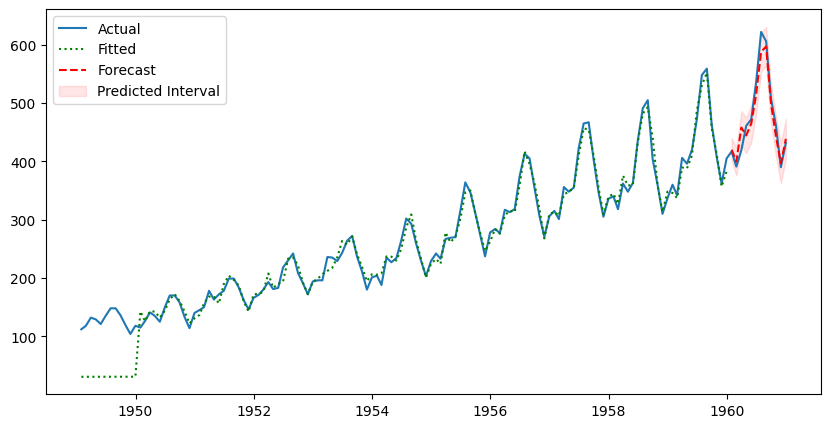

In [5]:
#
# code 4.4
#

# 学習データ期間の予測値を取得
fitted = model.predict_in_sample()

# 将来12か月間の予測（予測区間付き）
forecast, conf = model.predict(
    n_periods=12,         # 予測期間（12ヶ月分）
    return_conf_int=True, # 予測区間を返す
    alpha=0.05,           # 予測区間の信頼水準（95%予測区間）
)

# 予測結果をプロット
plot_prediction_results(df_ap.y, fitted, forecast, conf)

## 4.3 時系列のクロスバリデーション方法

### 4.3.2 時系列クロスバリデーション法

In [6]:
#
# code 4.5
#

from pmdarima.model_selection import RollingForecastCV

# RollingForecastCVクラスのインスタンスを作成
cv = RollingForecastCV(
    initial=36,  # 初期の訓練用データ期間を36ヶ月に設定
    h=12,        # 先の12か月のデータを予測対象とする
    step=3       # ローリングするステップ数を3ヶ月ずつとする
)

# 時系列データを配列に変換し取得
y = df_ap['y'].values

# クロスバリデーションの分割情報の取得
tscv = cv.split(y)

In [7]:
#
# code 4.6
#

# tscvから最初の3つの分割を取り出して表示
for i, (train_idx, test_idx) in enumerate(tscv):
    print(f"\n分割 {i+1}:")
    print("訓練データのインデックス範囲: "
          f"{train_idx[0]} - {train_idx[-1]}")
    print("検証データのインデックス範囲: "
          f"{test_idx[0]} - {test_idx[-1]}")
    if i >= 2:  # 最初の3つの分割のみ表示
        break


分割 1:
訓練データのインデックス範囲: 0 - 35
検証データのインデックス範囲: 36 - 47

分割 2:
訓練データのインデックス範囲: 0 - 38
検証データのインデックス範囲: 39 - 50

分割 3:
訓練データのインデックス範囲: 0 - 41
検証データのインデックス範囲: 42 - 53


In [8]:
#
# code 4.7
#

# 時系列データに対してクロスバリデーションを実施し、MAEとMAPEを計算する関数
def perform_ARIMA_tscv(
    y_values, # 時系列データ
    tscv,     # 時系列CVの分割情報
    m=0,      # 季節周期
):
    # MAEとMAPEを保存するリスト
    mae_list = []
    mape_list = []
    
    # クロスバリデーションの実施
    for train_idx, test_idx in tscv:

        # 訓練データと検証データの取得
        train_data = y_values[train_idx]  # 訓練データ
        test_data = y_values[test_idx]    # 検証データ

        # 訓練データでARIMAモデルを学習
        if m == 0:
            model = AutoARIMA(seasonal=False) 
        else:
            model = AutoARIMA(seasonal=True, m=m) 
        model.fit(train_data)

        # 検証データの期間を予測
        forecast = model.predict(n_periods=len(test_data))

        # 評価指標を計算
        mae = mean_absolute_error(test_data, forecast)
        mape = mean_absolute_percentage_error(test_data, forecast)
        mae_list.append(mae)    # 計算したMAEをリストに追加
        mape_list.append(mape)  # 計算したMAPEをリストに追加

    # 全クロスバリデーションの平均MAEとMAPEを計算
    mean_mae = np.mean(mae_list)
    mean_mape = np.mean(mape_list)

    # 戻り値: (平均MAE, 平均MAPE)
    return mean_mae, mean_mape

In [9]:
#
# code 4.8
#

m_mae, m_mape = perform_ARIMA_tscv(
    y_values = y,       # 時系列データ
    tscv = cv.split(y), # 時系列CVの分割情報
    m=12,               # ARIMAモデルの期間（季節周期）
)
print(f"CV MAE: {m_mae:.2f}")
print(f"CV MAPE: {m_mape*100:.2f}%")

CV MAE: 16.98
CV MAPE: 5.40%


In [10]:
#
# code 4.9
#

from pmdarima.model_selection import SlidingWindowForecastCV

# SlidingWindowForecastCVクラスのインスタンスを作成
cv = SlidingWindowForecastCV(
    window_size=36,  # 過去36か月分のデータを使用してモデルを学習
    h=12,            # 先の12か月のデータを予測対象とする
    step=3           # スライディングウィンドウを3か月ずつ移動
)

# 時系列データを配列に変換し取得
y = df_ap['y'].values

# クロスバリデーションの分割情報の取得
tscv = cv.split(y)

In [11]:
#
# code 4.10
#

# tscvから最初の3つの分割を取り出して表示
for i, (train_idx, test_idx) in enumerate(tscv):
    print(f"\n分割 {i+1}:")
    print("訓練データのインデックス範囲: "
          f"{train_idx[0]} - {train_idx[-1]}")
    print("検証データのインデックス範囲: "
          f"{test_idx[0]} - {test_idx[-1]}")
    if i >= 2:  # 最初の3つの分割のみ表示
        break


分割 1:
訓練データのインデックス範囲: 0 - 35
検証データのインデックス範囲: 36 - 47

分割 2:
訓練データのインデックス範囲: 3 - 38
検証データのインデックス範囲: 39 - 50

分割 3:
訓練データのインデックス範囲: 6 - 41
検証データのインデックス範囲: 42 - 53


In [12]:
#
# code 4.11
#

m_mae, m_mape = perform_ARIMA_tscv(
    y_values = y, # 時系列データ
    tscv = cv.split(y), # 時系列CVの分割情報
    m=12, # ARIMAモデルの期間（季節周期）
)
print(f"CV MAE: {m_mae:.2f}")
print(f"CV MAPE: {m_mape*100:.2f}%")

CV MAE: 16.60
CV MAPE: 5.20%


### 4.3.3 ホールドアウト×クロスバリデーション

In [13]:
#
# code 4.12
#

from pmdarima.model_selection import train_test_split

# 時系列データを配列に変換し取得
y = df_ap['y'].values

# 時系列データをホールドアウト方式で分割（直近12ヶ月がテストデータ）
train_all, test_final = train_test_split(
    y,            # 分割対象の時系列データ
    test_size=12, # 直近12ヶ月分をテストデータ　
)

In [14]:
#
# code 4.13
#

import optuna
from pmdarima import AutoARIMA
from pmdarima.model_selection import RollingForecastCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Optunaの目的関数の設定
def objective(trial):
    
    # 試行する複数の季節性の周期
    m = trial.suggest_int(
        name='m', 
        low=0,      # 最小値
        high=12,    # 最大値
    )

    # RollingForecastCVクラスのインスタンスを作成
    cv = RollingForecastCV(
        initial=36, # 初期の訓練用データ期間を36ヶ月に設定
        h=12,       # 先の12か月のデータを予測対象とする
        step=3      # ローリングするステップ数を3ヶ月ずつとする
    )

    # クロスバリデーションの分割情報の取得
    tscv = cv.split(train_all)

    # perform_ARIMA_tscv関数を使用して評価指標を計算
    mae, _ = perform_ARIMA_tscv(train_all, tscv, m)

    # 戻り値として評価指標を返す
    return mae

In [15]:
#
# code 4.14
#

# Studyオブジェクトの作成（最小化問題として設定）
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=123)
)

# ハイパーパラメータの最適化実行
study.optimize(
    objective,   # 目的関数
    n_trials=10, # 10回試行
    n_jobs=-1,   # 全CPUを使用する
)

# 最良の周期を取得
best_m = study.best_params['m']
print(f"Best m: {best_m}")

Best m: 12


In [16]:
#
# code 4.15
#

# CV で得られた最良の周期でモデルを学習
model = AutoARIMA(
    seasonal=True, 
    m=best_m, 
)
model.fit(train_all)

# テストデータ期間を予測
forecast = model.predict(n_periods=len(test_final))

# 評価指標を計算
mae = mean_absolute_error(test_final, forecast)
mape = mean_absolute_percentage_error(test_final, forecast)

# 結果を出力
print(f"MAE on test: {mae:.2f}")
print(f"MAPE on test: {mape*100:.2f}%")

MAE on test: 14.90
MAPE on test: 3.10%


In [17]:
#
# Prophetモデル用のデータの準備
#

# Prophet用データフレームに変換（'ds'と'y'列で表現）
df_prophet = pd.DataFrame({
    'ds': df_ap.index,
    'y': df_ap['y'].values
})

# データを学習データとテストデータに分割
train_all, test_final = train_test_split(
    df_prophet, 
    test_size=12  # 直近12ヶ月分をテストデータ
)

In [18]:
#
# code 4.16
#

from prophet import Prophet

# Prophetモデル版
# 時系列データに対してCVを実施してMAEとMAPEを計算する関数
def perform_prophet_cv(
    df,                      # 時系列データ(DataFrame with 'ds' and 'y' columns)
    tscv,                    # 時系列CVの分割情報
    changepoint_prior_scale, # トレンドの柔軟性を制御
    seasonality_prior_scale, # 季節性の柔軟性を制御
    growth,                  # トレンドの種類
    seasonality_mode,        # 季節性モデル（加法か乗法か）
):
    # CVの評価指標を格納するリスト
    mae_list = []
    mape_list = []

    # CVを実施
    for train_idx, test_idx in tscv:

        # 訓練データと検証データの取得
        train_data = df.iloc[train_idx]
        test_data = df.iloc[test_idx]

        # Prophetモデルの学習
        model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            growth=growth,
            seasonality_mode=seasonality_mode
        )

        # モデルの学習
        model.fit(train_data)

        # 予測期間の設定
        future = model.make_future_dataframe(
            periods=len(test_data), 
            freq='M'
        )

        # 予測の実行
        forecast = model.predict(future)

        # 検証データ期間の予測値を取得
        y_pred = forecast.iloc[-len(test_data):]['yhat'].values
        y_true = test_data['y'].values  

        # 評価指標を計算
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        # 評価指標をリストに追加
        mae_list.append(mae)
        mape_list.append(mape)

    # 戻り値: (平均MAE, 平均MAPE)
    return np.mean(mae_list), np.mean(mape_list)

In [19]:
#
# code 4.17
#

import optuna
from pmdarima.model_selection import RollingForecastCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Optunaのobjective関数の定義
def objective(trial):

    # トレンドの柔軟性を制御するパラメータ
    changepoint_prior_scale = trial.suggest_float(
        'changepoint_prior_scale',
        0.001, 0.5,
        log=True  # 対数スケールでの探索を指定
    )

    # 季節性の柔軟性を制御するパラメータ
    seasonality_prior_scale = trial.suggest_float(
        'seasonality_prior_scale',
        0.01, 10.0,
        log=True  # 対数スケールでの探索を指定
    )

    # トレンドの種類
    growth = trial.suggest_categorical(
        'growth',
        ['linear']  # logisticは除外
    )

    # 季節性モデルの種類（加法か乗法か）
    seasonality_mode = trial.suggest_categorical(
        'seasonality_mode',
        ['additive', 'multiplicative']
    )

    # RollingForecastCVの設定
    cv = RollingForecastCV(
        initial=36,  # 初期の訓練用データ期間を36ヶ月に設定
        h=12,        # 先の12か月のデータを予測対象とする
        step=3       # ローリングするステップ数を3ヶ月ずつとする
    )

    # クロスバリデーションの分割情報の取得
    tscv = cv.split(train_all.values)  

    # 評価指標の計算
    mae, _ = perform_prophet_cv(
        train_all, 
        tscv, 
        changepoint_prior_scale,
        seasonality_prior_scale,
        growth,
        seasonality_mode
    )
    
    # 戻り値: MAE
    return mae

In [20]:
#
# code 4.18
#

# Studyオブジェクトの作成（最小化問題として設定）
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=123)
)

# ハイパーパラメータの最適化実行
study.optimize(
    objective,
    n_trials=10000,
    n_jobs=-1
)

# 最適なパラメータの取得と表示
best_params = study.best_params
print("Best parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best parameters:
changepoint_prior_scale: 0.024159437996275124
seasonality_prior_scale: 0.06539669782956342
growth: linear
seasonality_mode: multiplicative


In [21]:
#
# code 4.19
#

# 最適なパラメータでモデルを学習
final_model = Prophet(**best_params)
final_model.fit(train_all)

# テストデータ期間の予測
future = final_model.make_future_dataframe(
    periods=len(test_final), 
    freq='M'
)
forecast = final_model.predict(future)

# テストデータの評価
test_pred = forecast.iloc[-len(test_final):]['yhat'].values
mae = mean_absolute_error(test_final['y'].values, test_pred)
mape = mean_absolute_percentage_error(test_final['y'].values, test_pred)

# 結果を出力
print(f"MAE on test: {mae:.2f}")
print(f"MAPE on test: {mape*100:.2f}%")

MAE on test: 17.69
MAPE on test: 3.62%


## 4.4 残差分析によるモデル診断

In [22]:
#
# code 4.20
#

from pmdarima.arima import auto_arima

# データフレームをコピー
df_tbl = df_ap.copy()

# モデルの作成
model = auto_arima(
    df_tbl['y'],
    seasonal=True,
    m=12
)

# 予測値（学習データと同じ期間）を追加
df_tbl['pred'] = model.predict_in_sample()

# 残差の計算
df_tbl['res'] = df_tbl['y'] - df_tbl['pred']
df_tbl = df_tbl[12:] #不安定な初期12ヶ月を削除

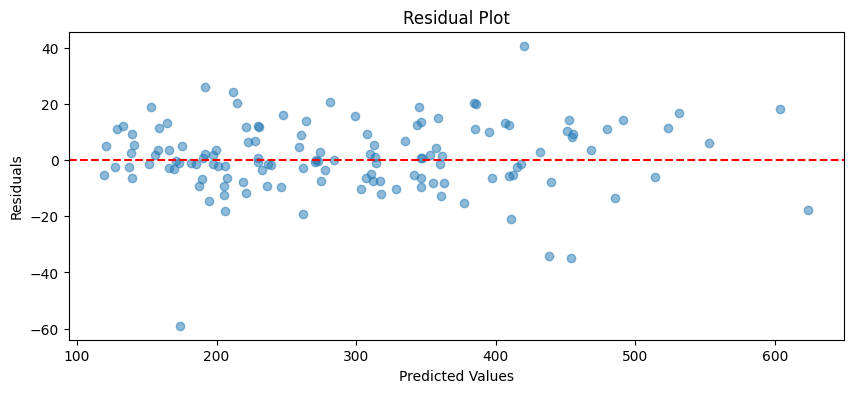

In [23]:
#
# code 4.21
#

# 残差プロット
plt.figure(figsize=(10, 4))
plt.scatter(df_tbl['pred'], df_tbl['res'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

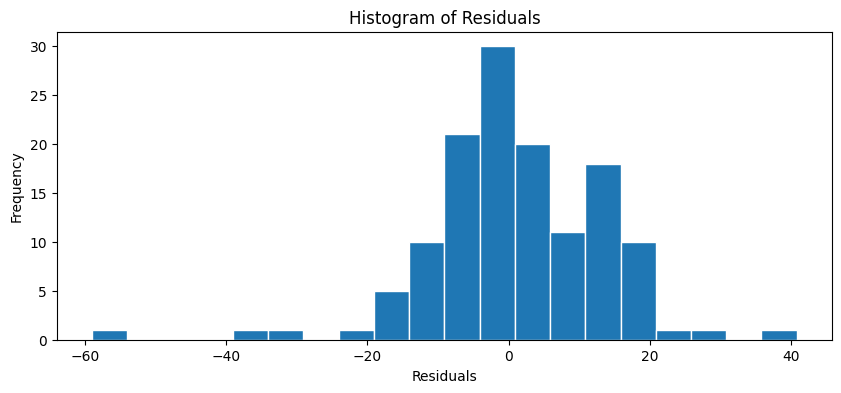

In [24]:
#
# code 4.22
#

# 残差のヒストグラム
plt.figure(figsize=(10, 4))
plt.hist(df_tbl['res'], bins=20, edgecolor='w')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

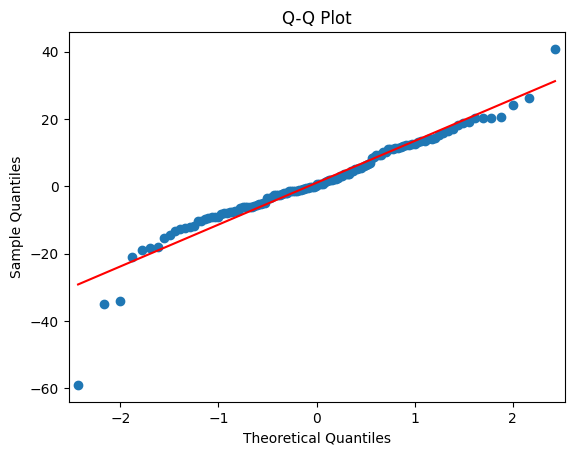

In [25]:
#
# code 4.23
#

# Q-Q プロット
import statsmodels.api as sm

sm.qqplot(df_tbl['res'], line='s')
plt.title("Q-Q Plot")
plt.show()

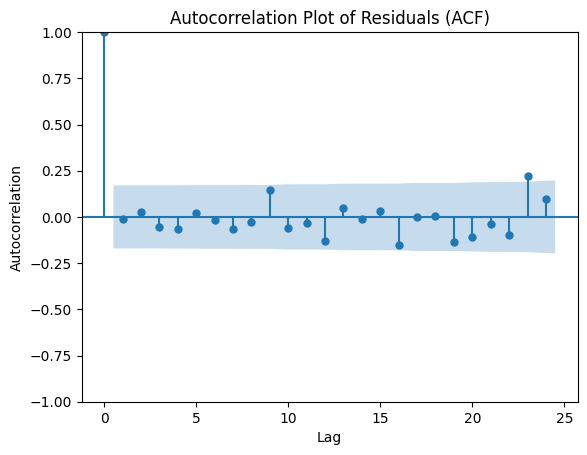

In [26]:
#
# code 4.24
#

# 残差の自己相関プロット
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_tbl['res'].dropna(), lags=24)
plt.title("Autocorrelation Plot of Residuals (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

In [27]:
#
# code 4.25
#

# シャピロ・ウィルク検定による正規性の検討
from scipy.stats import shapiro

stat_sw, p_sw = shapiro(df_tbl['res'].dropna())
print(f"Shapiro-Wilk Test: stat={stat_sw:.4f}, p={p_sw:.4f}")

Shapiro-Wilk Test: stat=0.9436, p=0.0000


In [28]:
#
# code 4.26
#

# ラン検定によるランダム性の確認
from statsmodels.sandbox.stats.runs import runstest_1samp

stat_runs, p_runs = runstest_1samp(
    df_tbl['res'].dropna(), 
    correction=True
)
print(f"Runs Test: stat={stat_runs:.4f}, p={p_runs:.4f}")

Runs Test: stat=-0.6591, p=0.5099


In [29]:
#
# code 4.27
#

# リュング・ボックス検定による自己相関の確認
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(
    df_tbl['res'].dropna(), 
    lags=[12], 
    return_df=True
)
print(lb_test)

     lb_stat  lb_pvalue
12  8.039604   0.782028


## 4.5 予測区間の算出

In [30]:
#
# code 4.28
#

from typing import Optional, Tuple, Iterator

# 指定された時刻 t の特徴量ベクトルを構築する関数
def build_feature_vector(
    t: int,                         # 現在の時刻インデックス (整数値)
    y_array: np.ndarray,            # 目的変数の時系列データ (1次元配列)
    X_array: Optional[np.ndarray],  # 外生変数 (2次元配列または None)
    use_lags: bool,                 # ラグ特徴量を使用するか (True/False)
    max_lag: int,                   # 最大のラグサイズ (整数値)
    use_exog: bool                  # 外生変数データを使用するか (True/False)
) -> np.ndarray:
    feats = []

    # y のラグ特徴量を追加
    if use_lags and max_lag > 0:
        for lag in range(1, max_lag + 1):
            feats.append(y_array[t - lag])
    
    # 外生変数 X を追加
    if use_exog and (X_array is not None):
        feats.extend(X_array[t].tolist()) 
	
    # 1行に整形して返す
    return np.array(feats, dtype=float).reshape(1, -1)  

In [31]:
#
# code 4.29
#

# 学習データセット(X, y)を構築する関数
# 指定インデックス範囲に基づき、特徴量行列 X と目的変数ベクトル y を生成
def make_train_xy(
    y_array: np.ndarray,           # 目的変数データ
    X_array: Optional[np.ndarray], # 追加の外生変数データ
    idx_array: np.ndarray,         # 学習データのインデックス
    use_lags: bool,                # 目的変数のラグ特徴量を使用するか (True/False)
    max_lag: int,                  # 目的変数のラグ特徴量の最大ラグ数
    use_exog: bool                 # 追加の外生変数を使用するか (True/False)
):
    # 学習データがない場合に空のデータを返す
    if len(idx_array) == 0:
        return np.empty((0, 0)), np.empty((0,))  

	# インデックスの始点と終点
    start_t, end_t = idx_array[0], idx_array[-1]  

    # 特徴量データとターゲット変数データを保持するリストを初期化
    X_list, y_list = [], []

    # ラグが必要な場合は開始インデックスを調整
    offset = max_lag if use_lags else 0

	# 特徴量を生成
    for t in range(start_t + offset, end_t + 1):
        fv = build_feature_vector(
            t, y_array, X_array,
            use_lags, max_lag, use_exog
        )  
        X_list.append(fv.ravel())   # 特徴量ベクトルをリストに追加
        y_list.append(y_array[t])   # 対応するy値をリストに追加
    if len(X_list) == 0:
        return np.empty((0, 0)), np.empty((0,)) 

    # リストを配列に変換して返す
    X_mat = np.array(X_list)
    y_vec = np.array(y_list)
    return X_mat, y_vec

In [32]:
#
# code 4.30
#

# 時系列CCPで予測区間幅を計算する関数
def ccp_recursive_multi_step_general(
    y: np.ndarray,                                      # 目的変数データ
    X: Optional[np.ndarray],                            # 追加の外生変数データ
    cv_splits: Iterator[Tuple[np.ndarray, np.ndarray]], # CV 分割情報
    model_class,                                        # 学習モデル
    H: int = 3,                                         # 何ステップ分先まで予測するか
    pred_alpha: float = 0.1,                            # 予測区間の信頼水準
    use_lags: bool = True,                              # 目的変数のラグ特徴量を使用するか
    max_lag: int = 2,                                   # 目的変数のラグ特徴量の最大ラグ
    use_exog: bool = True,                              # 追加の外生変数を使用するか
    **model_kwargs                                      # モデルに渡す追加のパラメータ
):
    # 各予測ステップの残差リスト初期化
    residuals_h = [[] for _ in range(H)]

    # 各分割 (訓練と校正のセット)について処理を行う
    for (train_idx, test_idx) in cv_splits:
        if len(train_idx) == 0 or len(test_idx) == 0:
            continue  # データ分割が空の場合はスキップ

        # 訓練期間のデータ範囲
        train_start, train_end = train_idx[0], train_idx[-1]  

        # 校正期間のデータ範囲
        cal_start, cal_end = test_idx[0], test_idx[-1]  

        # 訓練データセット (X, y) を構築
        X_train, y_train = make_train_xy(
            y, X, train_idx, use_lags, max_lag, use_exog)

        # 訓練データでモデル学習
        model = model_class(**model_kwargs)
        if len(X_train) > 0:
            model.fit(X_train, y_train)
        else:
            continue  # 訓練データが空の場合はスキップ

        # 校正期間で再帰的な予測を実施し、誤差を記録
        y_known = y.copy()
        for t in range(cal_start, cal_end + 1):
            for h in range(1, H + 1):
                future_t = t + h
                if future_t >= len(y):
                    break  # データ範囲を超えたら終了
                try:
                    # 特徴量を生成
                    fv = build_feature_vector(
                        future_t, y_known, X,
                        use_lags, max_lag, use_exog
                    )  
                except IndexError:
                    break  # ラグ不足でエラーが発生した場合も終了
                # 予測値
                y_hat = model.predict(fv)[0]
                # 誤差 = 真の値 - 予測値  
                e = y[future_t] - y_hat  
                # hステップ目の残差を記録
                residuals_h[h - 1].append(e)  
                # 再帰的予測用にy_knownを更新
                y_known[future_t] = y_hat  
                
    # 予測区間幅を計算してリストに格納
    width_h = []
    for h in range(1, H + 1):
        # 残差の絶対値を取得
        abs_res = np.abs(residuals_h[h - 1])  
        if len(abs_res) == 0:
            width_h.append(0.0)  # 残差がない場合は幅は0
        else:
            # 与えられた信頼水準から分位点を計算
            q = np.quantile(abs_res, 1 - pred_alpha)  
            width_h.append(q)

    # 予測区間幅と残差リストを返す
    return width_h, residuals_h

In [33]:
#
# code 4.31
#

from pmdarima.model_selection import train_test_split

# 学習データとテストデータに分ける
y_train, y_test = train_test_split(
    df_ap['y'], 
    test_size=12
)

In [34]:
#
# code 4.32
#

from sklearn.linear_model import RidgeCV
from pmdarima.model_selection import RollingForecastCV

# RollingForecastCVクラスのインスタンスを作成
cv = RollingForecastCV(
    initial=36,                     # 初期の訓練用データ期間を36ヶ月に設定
    h=12,                           # 先の12か月のデータを予測対象とする
    step=1                          # ローリングするステップ数を3ヶ月ずつとする
)

# パラメータ設定
H = 12                              # 最大予測ステップ
pred_alpha = 0.05                   # 予測区間の信頼レベル
use_lags = True                     # ラグ特徴量を使用
max_lag = 12                        # 最大のラグ数
use_exog = False                    # 外部変数は使用しない

# 時系列CCPで予測区間幅を計算
widths, residuals = ccp_recursive_multi_step_general(
    y=y_train.values,                # 目的変数
    X=None,                          # 外生変数は使用しない
    cv_splits=cv.split(y_train),
    H=H, 
    pred_alpha=pred_alpha,
    use_lags=use_lags,
    max_lag=max_lag,
    use_exog=use_exog,
    model_class=RidgeCV,             # RidgeCV回帰モデルを使用
    alphas=np.logspace(-3, 3, 1000)  # Ridgeのα値の探索範囲
)

# 各ステップごとに予測区間の幅を出力
for step, width in enumerate(widths, start=1):
    print(f"{step} 先予測の予測区間の幅: {width}")

1 先予測の予測区間の幅: 45.09864053791801
2 先予測の予測区間の幅: 47.303124898965095
3 先予測の予測区間の幅: 51.36843881154095
4 先予測の予測区間の幅: 54.693867193013155
5 先予測の予測区間の幅: 59.118012905398615
6 先予測の予測区間の幅: 61.82566022632674
7 先予測の予測区間の幅: 63.87338805892998
8 先予測の予測区間の幅: 65.65040821684723
9 先予測の予測区間の幅: 67.9299782560119
10 先予測の予測区間の幅: 70.0327954042567
11 先予測の予測区間の幅: 73.42143920010884
12 先予測の予測区間の幅: 78.31795777525431


In [35]:
#
# code 4.33
#

# 最終モデル作成: 学習データ全体を使用してモデルを構築
final_model = RidgeCV()

# 学習データ全体用の特徴量行列とターゲット変数を作成
final_X_train, final_y_train = make_train_xy(
    y_array=y_train,
    X_array=None,
    idx_array=np.arange(len(y_train)), 
    use_lags=use_lags,
    max_lag=max_lag,
    use_exog=use_exog
)

# モデル学習
final_model.fit(final_X_train, final_y_train)

In [36]:
#
# code 4.34
#

# 予測結果を格納するリスト
preds, lower_bounds, upper_bounds = [], [], []

# 既知のy
y_known = np.concatenate([
    y_train, 
    np.full(len(df_ap['y']) - len(y_train), np.nan)
])

# テストデータの開始インデックス
test_start_idx = len(y_train)  

# テストデータ期間の各時点で予測実行
for t in range(test_start_idx, test_start_idx + len(y_test)):

    # 特徴量生成: ラグを考慮
    features = build_feature_vector(
        t=t,
        y_array=y_known,
        X_array=None,
        use_lags=use_lags,
        max_lag=max_lag,
        use_exog=use_exog
    )

    # 予測値を計算
    pred = final_model.predict(features)[0]
    preds.append(pred)                          # 各予測値をリストに追加

    # 予測区間の幅を取得
    step_idx = min(H - 1, t - test_start_idx)   # Hステップ以上は最大幅を使用
    interval_width = widths[step_idx]
    lower_bounds.append(pred - interval_width)  # 下限値を計算
    upper_bounds.append(pred + interval_width)  # 上限値を計算

    # 再帰的予測: y_knownに予測値を更新
    y_known[t] = pred

# 予測ごとに予測値と予測区間を出力
preds_bounds = zip(preds, lower_bounds, upper_bounds)
for i, (pred, lower, upper) in enumerate(preds_bounds, 1):
    print(f"{i} 先予測: 予測値 = {pred}, 予測区間 = [{lower}, {upper}]")

1 先予測: 予測値 = 395.35037285893526, 予測区間 = [350.25173232101724, 440.4490133968533]
2 先予測: 予測値 = 381.0014629162444, 予測区間 = [333.6983380172793, 428.3045878152095]
3 先予測: 予測値 = 427.2777022150986, 予測区間 = [375.90926340355765, 478.64614102663955]
4 先予測: 予測値 = 426.4432062926124, 予測区間 = [371.74933909959924, 481.13707348562554]
5 先予測: 予測値 = 466.11202076744087, 予測区間 = [406.9940078620423, 525.2300336728395]
6 先予測: 予測値 = 512.1022270907182, 予測区間 = [450.27656686439144, 573.9278873170449]
7 先予測: 予測値 = 597.5266252173615, 予測区間 = [533.6532371584315, 661.4000132762915]
8 先予測: 予測値 = 607.1613843193647, 予測区間 = [541.5109761025175, 672.811792536212]
9 先予測: 予測値 = 526.9948028430965, 予測区間 = [459.0648245870846, 594.9247810991085]
10 先予測: 予測値 = 456.07084851749585, 予測区間 = [386.03805311323913, 526.1036439217526]
11 先予測: 予測値 = 404.1681036741894, 予測区間 = [330.7466644740806, 477.5895428742982]
12 先予測: 予測値 = 441.6256466228844, 予測区間 = [363.30768884763006, 519.9436043981387]


In [37]:
#
# code 4.35
#

# テストデータ期間の予測精度を計算
mae = mean_absolute_error(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)
print(f"テストデータの MAE: {mae:.2f}")
print(f"テストデータの MAPE: {mape*100:.2f}%")

# 予測区間の評価（実測値が予測区間に含まれる割合）
within_interval = (y_test >= lower_bounds) & (y_test <= upper_bounds)
within_interval_count = np.sum(within_interval)
coverage = within_interval_count / len(y_test)
print(f"\n予測区間の信頼水準: {(1-pred_alpha)*100}%")
print(f"実際のカバー率: {coverage*100:.2f}%")

# 結果をデータフレームにまとめて表示
test_final = pd.DataFrame({
    'y': y_test.values,
    'prediction': preds,
    'lower': lower_bounds,
    'upper': upper_bounds,
    'within_interval': within_interval
})
print("\n予測結果の詳細:")
print(test_final)

テストデータの MAE: 14.72
テストデータの MAPE: 3.13%

予測区間の信頼水準: 95.0%
実際のカバー率: 100.00%

予測結果の詳細:
                y  prediction       lower       upper  within_interval
1960-01-31  417.0  395.350373  350.251732  440.449013             True
1960-02-29  391.0  381.001463  333.698338  428.304588             True
1960-03-31  419.0  427.277702  375.909263  478.646141             True
1960-04-30  461.0  426.443206  371.749339  481.137073             True
1960-05-31  472.0  466.112021  406.994008  525.230034             True
1960-06-30  535.0  512.102227  450.276567  573.927887             True
1960-07-31  622.0  597.526625  533.653237  661.400013             True
1960-08-31  606.0  607.161384  541.510976  672.811793             True
1960-09-30  508.0  526.994803  459.064825  594.924781             True
1960-10-31  461.0  456.070849  386.038053  526.103644             True
1960-11-30  390.0  404.168104  330.746664  477.589543             True
1960-12-31  432.0  441.625647  363.307689  519.943604           

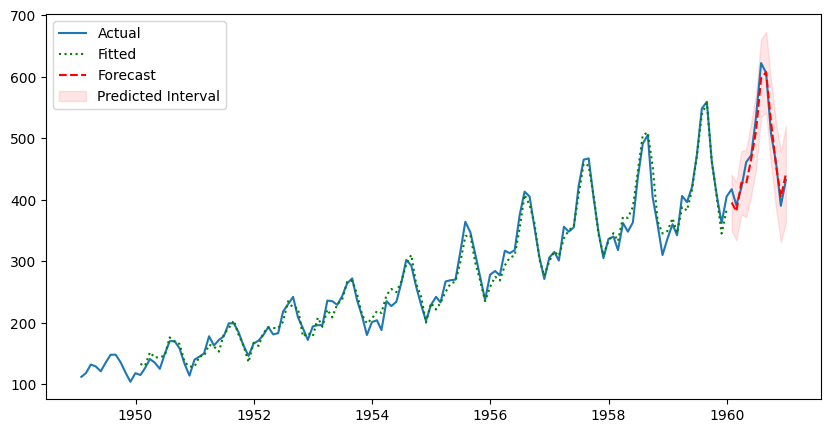

In [38]:
#
# code 4.36
#

# 学習データ期間の予測値
fitted = pd.Series(
    data=final_model.predict(final_X_train),
    index=y_train.index[max_lag:]
)

# テストデータ期間の予測値
forecast = test_final.prediction

# 予測区間
conf = np.column_stack([
    lower_bounds, 
    upper_bounds
])

# 結果をプロット
plot_prediction_results(
    y=df_ap['y'],
    fitted=fitted,
    forecast=forecast,
    conf=conf
)